<a href="https://colab.research.google.com/github/mdyao/Awesome-3D-AIGC/blob/main/Iter_Refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from google.colab import files

# step1:input calibration curve

In [3]:

# example_data
x_data = {# NO3， Absorbance
'0 mmol/L': [0.012, 0.027, 0.046, 0.091, 0.215, 0.424, 0.807, 1.148],
'0.005 mmol/L': [0.015, 0.033, 0.053, 0.091, 0.214, 0.411, 0.78, 1.104],
'0.01 mmol/L': [0.02, 0.039, 0.056, 0.096, 0.215, 0.41, 0.778, 1.106],
'0.025 mmol/L': [0.03, 0.048, 0.067, 0.109, 0.232, 0.433, 0.81, 1.152],
'0.05 mmol/L': [0.048, 0.064, 0.083, 0.127, 0.251, 0.45, 0.833, 1.171],
'0.1 mmol/L': [0.084, 0.096, 0.118, 0.158, 0.281, 0.481, 0.858, 1.196],
}

y_data = {
    'real_data': [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}



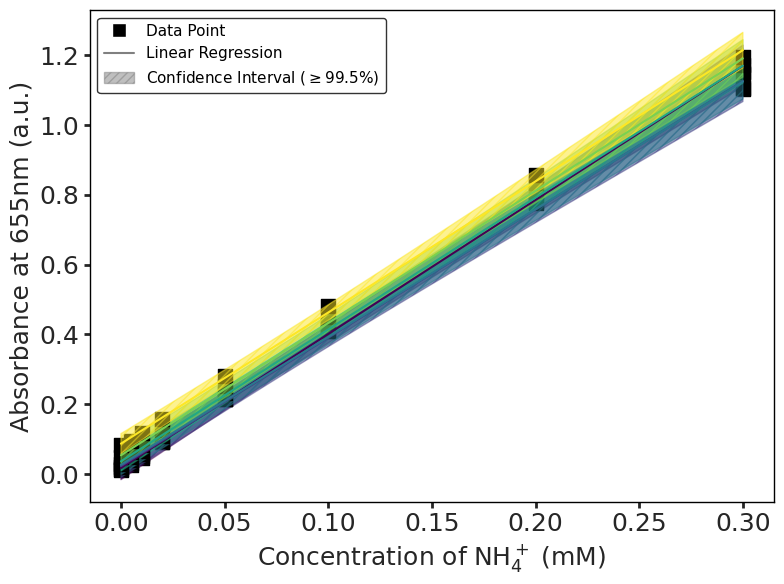

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns

def prediction_interval(model, x, y, x_new, alpha=0.005):
    y_pred = model.predict(x)
    n = len(y)
    mean_x = np.mean(x)
    dof = n - 2
    t = stats.t.ppf(1 - alpha / 2., dof)
    residuals = y - y_pred
    s_err = np.sum(np.power(residuals, 2))

    conf = t * np.sqrt((s_err / (n - 2)) * (1.0/n + np.power((x_new - mean_x), 2) /
            ((np.sum(np.power(x - mean_x, 2))))))

    y_new = model.predict([[x_new]])
    lower = y_new - conf
    upper = y_new + conf
    return y_new, lower, upper

def plot_data(x_data_dict, y_data, new_y=None, new_x_range=None, title='Linear regression and prediction intervals', xlabel='Real Value', ylabel='Absorbance at 655nm (a.u.)', savename=None, ncol=5):
    # Use seaborn theme
    sns.set(style="whitegrid")

    # Visualization
    plt.figure(figsize=(8, 6))

    # Prepare colors and labels
    colors = plt.cm.viridis(np.linspace(0, 1, len(x_data_dict)))

    # Plot each dataset
    handles_outside = []
    labels_outside = []
    for i, (label, x) in enumerate(x_data_dict.items()):
        y = y_data['real_data']
        x = np.array(x)
        y = np.array(y)

        # Linear regression
        lin_reg = LinearRegression()
        lin_reg.fit(y.reshape(-1, 1), x)  # Note the swap of x and y

        # Calculate confidence interval across the y range
        y_range = np.linspace(min(y), max(y), 100)  # Changed to y range
        x_preds = lin_reg.predict(y_range.reshape(-1, 1))  # Predict x using y range

        lower_bounds = []
        upper_bounds = []

        for y_val in y_range:
            _, lower, upper = prediction_interval(lin_reg, y.reshape(-1, 1), x, y_val)  # Swapped x and y
            lower_bounds.append(lower[0])
            upper_bounds.append(upper[0])

        # Plot data points and fitted line
        scatter_handle = plt.scatter(y, x, color='black', marker='s', s=100)  # Black square data points
        line_handle, = plt.plot(y_range, x_preds, color=colors[i])  # Fitted line
        fill_handle = plt.fill_between(
            y_range,
            lower_bounds,
            upper_bounds,
            color=colors[i],
            alpha=0.5,
            hatch='////'  # Add hatch style
        )

        handles_outside.append(fill_handle)
        labels_outside.append(f'{label}')

    # If new data point, plot it
    if new_y is not None and new_x_range is not None:
        x_min, x_max = new_x_range
        plt.hlines(new_y, x_min, x_max, colors='red', linestyles='dashed', label=f'Range at y={new_y:.2f}')
        plt.scatter([x_min, x_max], [new_y, new_y], color='red', edgecolor='black', s=100, zorder=5)
        plt.text(x_min, new_y, f'{x_min:.2f}', fontsize=12, color='red', ha='right', va='top')
        plt.text(x_max, new_y, f'{x_max:.2f}', fontsize=12, color='red', ha='left', va='top')

    # Legend outside the plot
    plt.gca().add_artist(plt.legend(handles=handles_outside, labels=labels_outside, loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol, handletextpad=0.5, labelspacing=0.5, frameon=False))

    # Create legend handles and labels
    scatter_handle = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, linestyle='None')  # Black square
    line_handle = plt.Line2D([0], [1], color='gray')
    fill_handle = plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5, hatch='////')  # Hatch style
    legend = plt.legend([scatter_handle, line_handle, fill_handle],
                        ['Data Point', 'Linear Regression', 'Confidence Interval ($\geq$99.5%)'],
                        loc='upper left',
                        frameon=True,  # Enable frame
                        edgecolor='black',  # Set edge color to black
                        bbox_transform=plt.gca().transAxes)

    legend.get_frame().set_linewidth(1)  # Set border width
    legend.get_frame().set_edgecolor('black')  # Border color

    # Set legend text color
    for text in legend.get_texts():
        text.set_color('black')

    # Set axis and grid lines
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    # Set border colors
    ax = plt.gca()
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)

    # Set tick marks
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))

    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    ax.xaxis.set_tick_params(which='major', labelsize=18, width=2, length=15, bottom='off', size=4, direction='out')
    ax.xaxis.set_tick_params(which='minor', width=1, length=4, bottom='off', size=4, direction='out')
    ax.yaxis.set_tick_params(which='both', labelsize=18, width=2, length=20, left='off', size=4, direction='out')

    # Hide grid lines
    plt.grid(False)

    plt.tight_layout()

    if savename is not None:
        plt.savefig(savename, dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

new_x_range=None
new_y = None
plot_data(x_data, y_data, new_y=new_y, new_x_range=new_x_range, title='Linear regression and prediction intervals (PH)', ncol=7, xlabel='Concentration of NH$^+_4$ (mM)')



#Step2: theoretical calculation

### PH value

In [ ]:
def calculate_OH_concentration(PH_value):
    # Function to calculate OH- concentration; replace with actual formula if needed
    return 10 ** -(14 - PH_value)

# Input pH value
PH_value_start = input("Please enter the pH value: ")

try:
    PH_value_start = float(PH_value_start)  # Convert input to float
    if PH_value_start > 14:
        print("Highly basic data.")
    else:
        # Input the starting and ending pH values
        PH_value_end = float(input("Please enter the ending pH value: "))

        # Calculate the OH- concentration difference
        OH_concentration_start = calculate_OH_concentration(PH_value_start)
        OH_concentration_end = calculate_OH_concentration(PH_value_end)
        OH_concentration_diff = OH_concentration_end - OH_concentration_start

        # Output the change in OH- concentration
        print(f"From starting pH {PH_value_start} to ending pH {PH_value_end}, the change in OH- concentration is {OH_concentration_diff:.2e} mol/L.")
except ValueError:
    print("Invalid input, please enter numerical values.")


Please enter the pH value: 1
Please enter the ending pH value: 14
From starting pH 1.0 to ending pH 14.0, the change in OH- concentration is 1.00e+00 mol/L.


### charge amount

In [6]:
def estimate_ammonia_concentration(coulombs):
  """
  Estimates the range of ammonia concentration after electrolysis.

  Args:
    coulombs: The amount of electric charge passed through the solution (in Coulombs).

  Returns:
    A tuple containing the estimated minimum and maximum ammonia concentrations (in mmol/L).
  """

  # Faraday's constant (in Coulombs/mol)
  FARADAY_CONSTANT = 96485

  # Number of electrons involved in the reduction of nitrate to ammonia
  ELECTRONS = 8

  # Calculate the moles of electrons transferred
  moles_electrons = coulombs / FARADAY_CONSTANT

  # Calculate the moles of ammonia produced (assuming 100% efficiency)
  moles_ammonia = moles_electrons / ELECTRONS

  # Assume a solution volume of 1 liter for simplicity (adjust as needed)
  volume = 1  # in liters

  # Calculate the estimated ammonia concentration (in mol/L)
  concentration = moles_ammonia / volume

  # Adjust concentration based on pH (this is a simplification and may need refinement)
  # Higher pH generally leads to higher ammonia concentration
  max_concentration = concentration #* 1.2  # Example adjustment factor

  # Convert concentrations to mmol/L
  max_concentration_mmol = max_concentration * 1000

  return  max_concentration_mmol

# # Example usage:
# coulombs = 100  # Replace with actual value
# ph = 8  # Replace with actual value

# min_conc, max_conc = estimate_ammonia_concentration(coulombs, ph)

# print(f"Estimated ammonia concentration range: {min_conc:.2f} - {max_conc:.2f} mmol/L")

total_sum = float(input("Please enter the charge amount: "))#这里的单位是什么？
max_conc = estimate_ammonia_concentration(total_sum)
print(f"The theoretical OH- production calculated from the transferred charge is: {max_conc:0.4f} mmol/L")

Please enter the charge amount: 300
The theoretical OH- production calculated from the transferred charge is: 0.3887 mmol/L


# Step3: Calculate dilution factor



In [ ]:
# User input for the maximum range
try:
    max_liangheng = float(input("Enter the maximum range (e.g., 0.3 mmol/L): "))
except ValueError:
    print("Invalid input, please enter a numerical value.")
    exit()

# Target concentration range
target_min = 0.01
target_max = 0.25

# Ensure the maximum concentration is available for calculation
if 'max_conc' not in locals():
    print("Maximum concentration (max_conc) is not defined. Ensure you have the correct input or calculation before running this code.")
    exit()

# Calculate dilution factors
dilution_factor_min = max(2, int(max_conc / target_max))  # Ensure dilution factor is greater than 1
dilution_factor_max = int(max_conc / target_min)

print(f"Calculated maximum concentration: {max_conc:.4f} mmol/L")

# Check the relationship between dilution factors
if dilution_factor_max < dilution_factor_min:
    print("No suitable dilution factors found; the target concentration range does not match the maximum range. Please adjust the target concentration range or recheck experimental conditions.")
else:
    # Set step size for reasonable intervals
    step = max(1, int((dilution_factor_max - dilution_factor_min) // 5))

    # Find suitable integer dilution factors
    suggested_dilutions = list(range(dilution_factor_min, dilution_factor_max + 1, step))

    # Output results
    if suggested_dilutions:
        print(f"To ensure the diluted concentration falls between {target_min} and {target_max} mmol/L,")
        print(f"and the dilution factor is greater than 1 and an integer, the suggested dilution factors are: {suggested_dilutions}")
    else:
        print("No suitable dilution factors found. Consider repeating the experiment or adjusting the target concentration range.")

# Additional guidance for suggested concentration range
print("Ensure the diluted intensity is between 0.4 and 0.8 for optimal results.")


Enter the maximum range (e.g., 0.3 mmol/L): 0.3
Calculated maximum concentration: 0.3887 mmol/L
To ensure the diluted concentration falls between 0.01 and 0.25 mmol/L,
and the dilution factor is greater than 1 and an integer, the suggested dilution factors are: [2, 9, 16, 23, 30, 37]
Ensure the diluted intensity is between 0.4 and 0.8 for optimal results.


# Step4.1: continuously dilute, and measure the intensity after each dilution

<!-- 根据理论计算得到的NH3浓度确定稀释倍数，不断稀释，并测量得到每次稀释后的强度，以及稀释后的计算理论值。 -->

Enter the intensity value for dilution factor 2: 0.2
Enter the intensity value for dilution factor 9: 0.3
Enter the intensity value for dilution factor 16: .4
Enter the intensity value for dilution factor 23: .3
Enter the intensity value for dilution factor 30: .8
Enter the intensity value for dilution factor 37: .9
The intensity values you entered are: [0.2, 0.3, 0.4, 0.3, 0.8, 0.9]
Threshold set to: 0.13333333333333336
Detected anomalous data:
Dilution factor 23 with intensity 0.3 (Residual: 0.25)
Filtered intensity values are: [0.2, 0.3, 0.4, 0.8, 0.9]
Corresponding dilution factors are: [2, 9, 16, 30, 37]


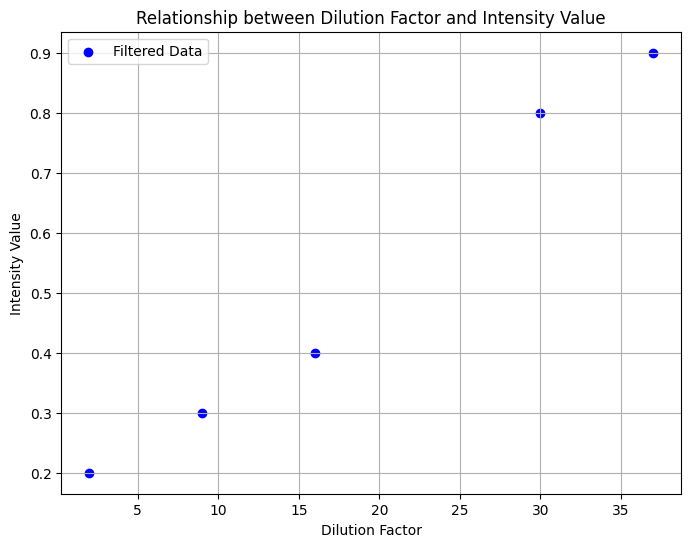

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Input suggested dilution factors
num_dilutions = len(suggested_dilutions)
intensities = []

for i in range(num_dilutions):
    while True:
        intensity_str = input(f"Enter the intensity value for dilution factor {suggested_dilutions[i]}: ")
        try:
            intensity = float(intensity_str)
            intensities.append(intensity)
            break
        except ValueError:
            print("Invalid input. Please enter a number.")

print("The intensity values you entered are:", intensities)

# Function to check linearity
def is_linear(x, y):
    model = LinearRegression()
    x = np.array(x).reshape(-1, 1)  # Reshape to column vector
    model.fit(x, y)
    y_pred = model.predict(x)
    residuals = y - y_pred
    # Evaluate linear fit quality using the standard deviation of residuals
    residual_std = np.std(residuals)
    return residual_std < 0.1  # Threshold can be adjusted

# Extract dilution factors
dilution_factors = np.array(suggested_dilutions)

# Check for linear relationship
if is_linear(dilution_factors, intensities):
    print("The intensity values are consistent with a linear trend.")
else:
    print("Warning: The intensity values do not follow a linear trend. Anomalous data detected.")

    # Perform linear fit
    model = LinearRegression()
    dilution_factors = np.array(suggested_dilutions).reshape(-1, 1)  # Reshape to column vector
    model.fit(dilution_factors, intensities)
    y_pred = model.predict(dilution_factors)
    residuals = np.abs(np.array(intensities) - y_pred)

    # Set threshold for anomalous data
    threshold = np.mean(residuals) * 1.5

    # Print anomalous data
    print(f"Threshold set to: {threshold}")
    print("Detected anomalous data:")
    for i, residual in enumerate(residuals):
        if residual > threshold:
            print(f"Dilution factor {suggested_dilutions[i]} with intensity {intensities[i]} (Residual: {residual:.2f})")

    # Filter out anomalous data
    filtered_dilutions = [suggested_dilutions[i] for i, residual in enumerate(residuals) if residual <= threshold]
    filtered_intensities = [intensities[i] for i, residual in enumerate(residuals) if residual <= threshold]

    # Print cleaned data
    print("Filtered intensity values are:", filtered_intensities)
    print("Corresponding dilution factors are:", filtered_dilutions)

    # Re-plot the data if needed
    if filtered_dilutions:
        plt.figure(figsize=(8, 6))
        plt.scatter(filtered_dilutions, filtered_intensities, color='blue', label='Filtered Data')
        plt.xlabel('Dilution Factor')
        plt.ylabel('Intensity Value')
        plt.title('Relationship between Dilution Factor and Intensity Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No data points meet the linear relationship criteria.")


# Step4.2: Obtain the range of ammonia, according to the diluted intensity and the calibration curve of the first step
<!-- 根据理论计算得到的NH3浓度确定稀释倍数，不断稀释，并测量得到每次稀释后的强度，以及稀释后的计算理论值。 -->

Please enter the measured intensity:0.3
Concentration range: Minimum = 0.05 mmol/L, Maximum = 0.08 mmol/L


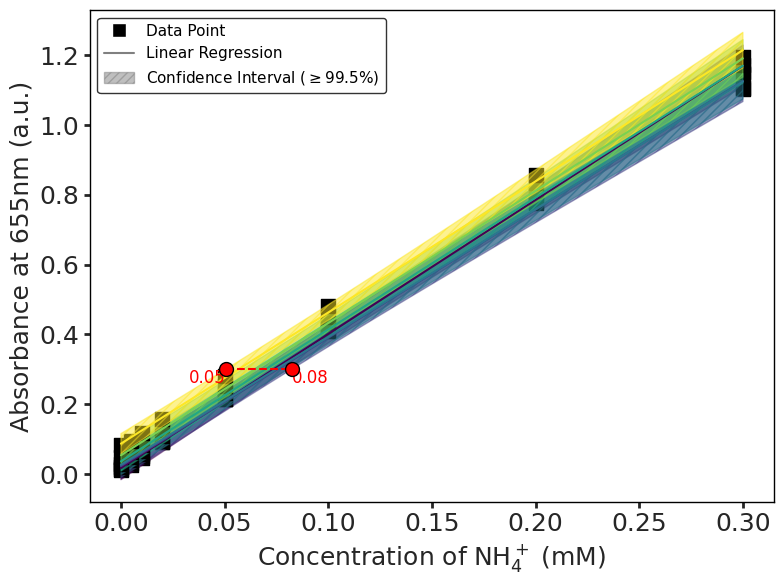

In [7]:

def calculate_y_range(x_data_dict, y_data, new_x, alpha=0.005):
    min_y = float('inf')
    max_y = float('-inf')

    for label, x in x_data_dict.items():
        y = y_data['real_data']
        x = np.array(x)
        y = np.array(y)

        # Linear regression
        lin_reg = LinearRegression()
        lin_reg.fit(x.reshape(-1, 1), y)

        # Calculate prediction interval for new x values
        y_new, lower, upper = prediction_interval(lin_reg, x.reshape(-1, 1), y, new_x, alpha)

        # Update min and max values
        min_y = min(min_y, lower[0])
        max_y = max(max_y, upper[0])

    return min_y, max_y

# Input new y value
new_y = float(input("Please enter the measured intensity:"))  # Example new y value

new_x_range = calculate_y_range(x_data, y_data, new_y)
print(f"Concentration range: Minimum = {new_x_range[0]:.2f} mmol/L, Maximum = {new_x_range[1]:.2f} mmol/L")

plot_data(x_data, y_data, new_y=new_y, new_x_range=new_x_range, title='Linear regression and prediction intervals (PH)', ncol=7, xlabel='Concentration of NH$^+_4$ (mM)')

## Step5: Based on the ammonia concentration, the state of the electrolyte terminal can be estimated, a color developer is configured, and the quasi-curve in this state can be measured again.

<!-- 反推OH根和NH3的浓度 -->

### input new calibration curve

<!-- # 强度，（稀释倍数，理论计算值的最大值，【根据理论计算的最大值 稀释倍数后的值】）
# 这里的计算得到的氨浓度是一个范围（浓度由:强度+之前测量的校准曲线得到）。
# 校准曲线选择是由NO3-浓度选择。


# 由氨浓度可以推测电解液末端的状态，配置显色剂，重新测量该状态下的校准曲线。

# 并及时使用该显色剂进行下一步实验，避免显色剂变化对实验造成误差。


# 之前校准曲线会有动态的变化，涉及到显色剂等实验因素的影响。 -->


In [9]:
import ast

# Guide the user to input x_data_dict line by line
x_data_dict = {}
index = 1
while True:
    print(f"Entering data for entry {index}:")  # Prompt indicating the current entry number
    label = input("Enter the solution condition (e.g., 'NO3+0.2 mmol/L') or type 'done' to finish input: ")
    if label.lower() == 'done':
        break
    values = input(f"Enter the intensity values for the condition '{label}' in the format [value1, value2, ...]: ")

    # Convert the string to a list
    try:
        values = ast.literal_eval(values)
        if isinstance(values, list):
            x_data_dict[label] = values
            index += 1  # Increment the data count
        else:
            print("The intensity values must be a [list]. Please re-enter.")
    except (ValueError, SyntaxError) as e:
        print("Input format error. Please check and re-enter. Error message:", e)

print("Solution conditions input completed:", x_data_dict)

# Guide the user to input y_data
print("\nNow input the real ammonia concentrations.")
real_data = input("Enter the real ammonia concentrations as a list (e.g., [0, 0.005, 0.01, 0.02]): ")

# Convert the string to a list
try:
    real_data = ast.literal_eval(real_data)
    if isinstance(real_data, list):
        y_data = {'real_data': real_data}
    else:
        print("The values must be a [list]. Please re-enter.")
except (ValueError, SyntaxError) as e:
    print("Input format error. Please check and re-enter. Error message:", e)

print("Real ammonia concentrations input completed:", y_data)




Entering data for entry 1:
Enter the solution condition (e.g., 'NO3+0.2 mmol/L') or type 'done' to finish input: NO3+0.2 mmol/L


KeyboardInterrupt: Interrupted by user

#Step6:Based on the new calibration curve, recalculate the concentration of NH3 in this electrolyte state



Please enter the measured intensity:0.7
Concentration range: Minimum = 0.16 mmol/L, Maximum = 0.19 mmol/L


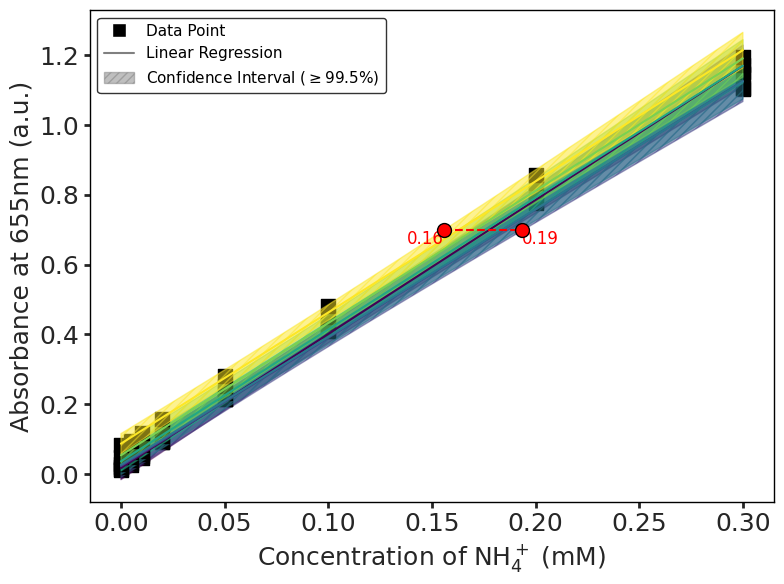

In [14]:

x_data = {# NO3
'0 mmol/L': [0.012, 0.027, 0.046, 0.091, 0.215, 0.424, 0.807, 1.148],
'0.005 mmol/L': [0.015, 0.033, 0.053, 0.091, 0.214, 0.411, 0.78, 1.104],
'0.01 mmol/L': [0.02, 0.039, 0.056, 0.096, 0.215, 0.41, 0.778, 1.106],
'0.025 mmol/L': [0.03, 0.048, 0.067, 0.109, 0.232, 0.433, 0.81, 1.152],
'0.05 mmol/L': [0.048, 0.064, 0.083, 0.127, 0.251, 0.45, 0.833, 1.171],
'0.1 mmol/L': [0.084, 0.096, 0.118, 0.158, 0.281, 0.481, 0.858, 1.196],
}

y_data = {
    'real_data': [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}


# Input new y value
new_y = float(input("Please enter the measured intensity:"))  # Example new y value

new_x_range = calculate_y_range(x_data, y_data, new_y)
print(f"Concentration range: Minimum = {new_x_range[0]:.2f} mmol/L, Maximum = {new_x_range[1]:.2f} mmol/L")

plot_data(x_data, y_data, new_y=new_y, new_x_range=new_x_range, title='Linear regression and prediction intervals (PH)', ncol=7, xlabel='Concentration of NH$^+_4$ (mM)')


# END